In [1]:
import time
import copy
import pickle
import json
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset, TensorDataset
from torch.utils.data.dataset import random_split
from torchsummary import summary
import torchvision.models as models
import torchvision.transforms as transforms

from keras.utils.np_utils import to_categorical  

In [2]:
# Enable gpu support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!gdown 1sc2qFcOeJp2hYAj50i8Xj9VwW6qfePAl

Downloading...
From: https://drive.google.com/uc?id=1sc2qFcOeJp2hYAj50i8Xj9VwW6qfePAl
To: /content/data.csv
100% 241M/241M [00:00<00:00, 279MB/s]


In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Data extraction and preprocessing

In [4]:
data = pd.read_csv('data.csv')


In [5]:
display(data.head())
data.shape

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


(28709, 2)

In [6]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [7]:
X = np.array([
              [i for i in map(int, row)] for row 
              in map(str.split, data['pixels'].values)
      ]).reshape((-1, 48, 48))

In [8]:
X.dtype

dtype('int64')

In [9]:
X.shape

(28709, 48, 48)

In [10]:
y = data['emotion']
display(y.value_counts())
y = y.values

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [11]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
)

# Dataset

In [12]:
class EmotionsDataset(Dataset):
  def __init__(self, X, y, standardization_mode, transforms=None, 
               augmentation_epochs=7, to_rgb=True):
    super().__init__()
    
    self.stransforms = transforms
    self.augmentation_epochs = augmentation_epochs

    self.standardization_mode = standardization_mode
    self.standardization_filename = 'mean_var.json'


    if self.stransforms:
      self.X, self.y = self._augment(X, y)
    else:
      self.X = torch.from_numpy(X).float().to(device)
      self.y = y

    self.y_categorical = torch.from_numpy(
        to_categorical(self.y, num_classes=7)
    ).float().to(device)

    self.X = self._standardize(self.X)
    if len(self.X.shape) != 4:
      self.X.unsqueeze_(1)

    if to_rgb:
      self.X = self.X.repeat(1, 3, 1, 1)
  
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, index):
    return self.X[index], self.y_categorical[index]
  
  def _standardize(self, X):
    if self.standardization_mode == 'fit_transform':
      mean, var = X.mean(), X.var()

      with open(self.standardization_filename, 'w', encoding ='utf8') as file:
        json.dump({
            'mean': float(mean),
            'var': float(var)
        }, file)

    elif self.standardization_mode == 'transform':
      with open(self.standardization_filename, 'r', encoding ='utf8') as file:
        data = json.load(file)
      
      mean, var = data['mean'], data['var']
    
    elif self.standardization_mode == 'None':
      return X
      
    else:
      raise TypeError(
          'Unkown option "standardization_mode"\n'
          'Choose from: fit_transform, transform\n'
      )
    
    return transforms.Normalize(mean, var)(X)
  
  def _augment(self, X, y):
    # Sampler
    counts = np.unique(y, return_counts=True)[1]
    class_weights = np.power(counts, -1, dtype=float)

    sample_weights = [class_weights[label] for i, label in enumerate(y)]

    sampler = WeightedRandomSampler(sample_weights, 
                                    num_samples=len(sample_weights),
                                    replacement=True)

    # Dataset
    dataset = TensorDataset(torch.from_numpy(X).unsqueeze(1),
                            torch.from_numpy(y_train))

    # DataLoaders
    dataset_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

    # Aumentation
    X_train_augmented, y_train_augmented = [], []
    for _ in range(self.augmentation_epochs):
      for batch in dataset_loader:
        X_train_augmented.append(transform(batch[0]).squeeze(0))
        y_train_augmented.append(batch[1])

    X_train_augmented = torch.stack(X_train_augmented).float().to(device)
    y_train_augmented = torch.stack(y_train_augmented).numpy()

    return X_train_augmented, y_train_augmented

# Augmentation

In [13]:
transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomAffine(degrees=(-15, 15), translate=(0.01, 0.15)),
      transforms.RandomPerspective(distortion_scale=0.35)
    ])

In [14]:
# Datasets
train = EmotionsDataset(X_train, y_train, 'fit_transform', transform)
val = EmotionsDataset(X_val, y_val, standardization_mode='transform')
test = EmotionsDataset(X_test, y_test, standardization_mode='transform')

# Data visualisation

In [15]:
target_names = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral',
}

In [34]:
def plot_images(X, y, transform=None, classes=7, columns=10):
  _X = np.zeros((classes * columns, 48, 48))
  _y = []
  
  X, y = copy.deepcopy(X), copy.deepcopy(y)

  if transform:
    X_tensor = torch.from_numpy(X).unsqueeze(1)
    X_augmented = torch.stack([transform(image_tensor) for image_tensor in X_tensor])

    X = X_augmented.squeeze(1).cpu()


  for label in range(classes):
    mask = (y == label)
    _X[columns * label : columns * label + columns] = X[mask, :][:columns]
    _y.extend([label] * columns)

  _, axes = plt.subplots(nrows=classes, ncols=columns, figsize=(15, 12))
  for ax, image, label in zip(axes.flatten(), _X, _y):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(image, cmap=plt.cm.gist_gray)
      ax.set_title(target_names[label])

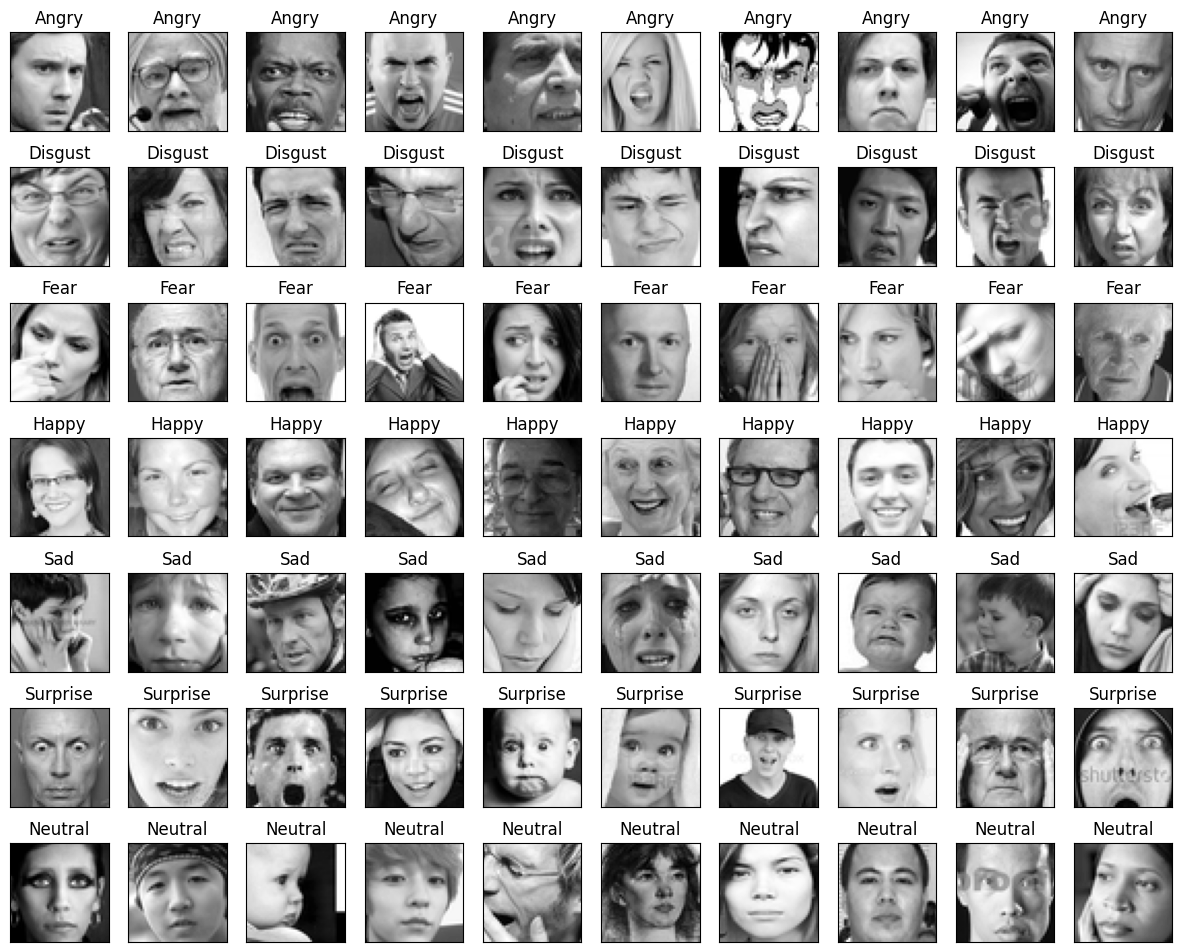

In [23]:
plot_images(X, y)

torch.Size([28709, 1, 48, 48])


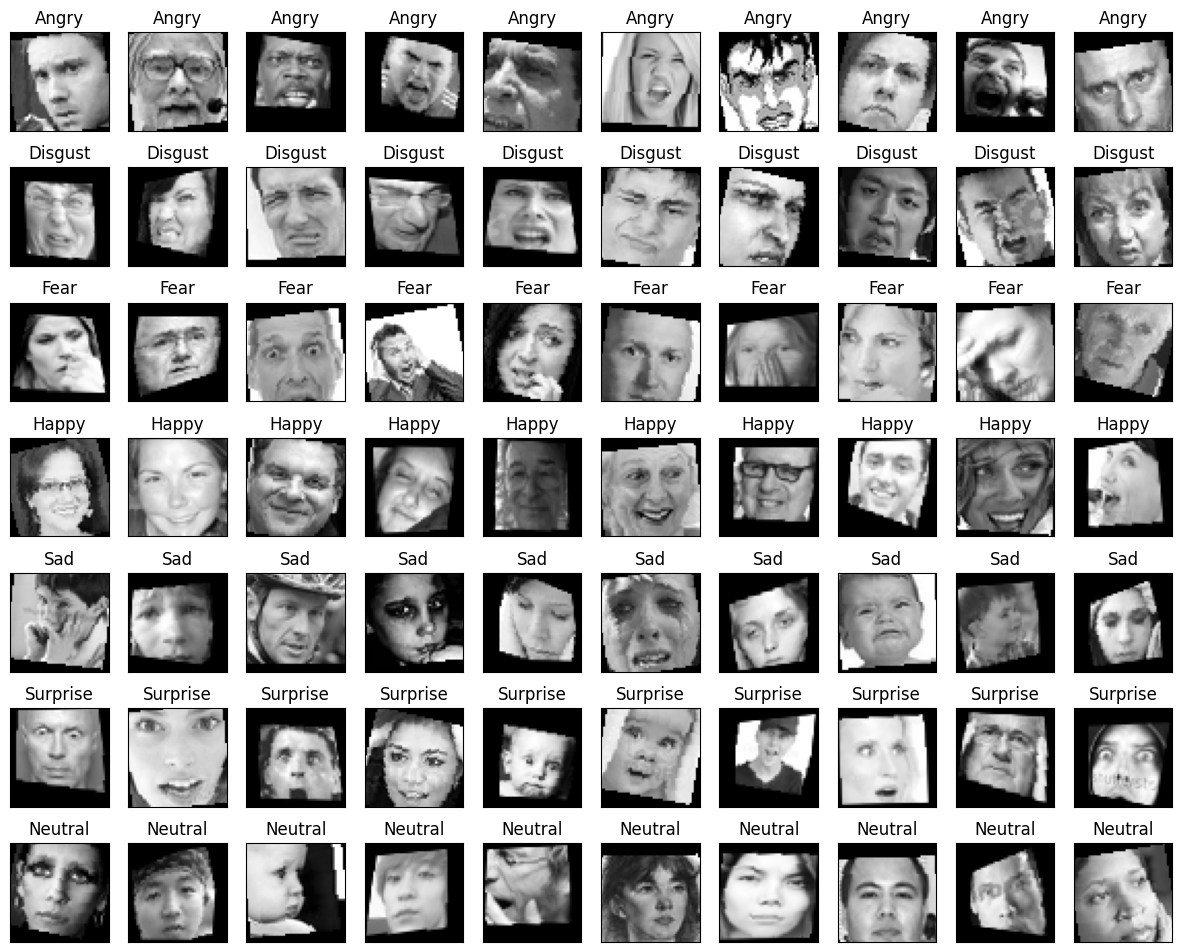

In [35]:
plot_images(X, y, transform)

# Augmentation expirements

In [ ]:
# _transform = transforms.Compose([
#       transforms.RandomHorizontalFlip(),
#       transforms.RandomPerspective(distortion_scale=0.35),
#       transforms.RandomAffine(degrees=(-15, 15), translate=(0.01, 0.15)),
#       transforms.RandomAdjustSharpness(sharpness_factor=150)
#     ])

# plot_images(X, y, _transform)

# Plots

In [ ]:
def plot_confusin_matrix(y_real, y_test):
  confusion_matrix = metrics.confusion_matrix(y_real, y_test)
  sns.heatmap(confusion_matrix, center=0, cmap='PiYG', annot=True)

  plt.show()

In [ ]:
def plot_loss(train_loss, test_loss, ylim=False):
  x = [i for i in range(1, len(train_loss) + 1)]

  plt.plot(x, train_loss, label='train')
  plt.plot(x, test_loss, label='test')

  if ylim:
    plt.ylim(0, 10)

  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [ ]:
def plot_accuracy(train_accuracies, test_accuracies, step):
  x = [i for i in range(1, step * len(train_accuracies) + 1, step)]

  plt.plot(x, train_accuracies, label='train')
  plt.plot(x, test_accuracies, label='validation')

  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

# Models

In [ ]:
class Net(nn.Module):
  def __init__(self, backbone):
    super(Net, self).__init__()
    
    backbone.fc = nn.Linear(backbone.fc.in_features, 1000)

    self.model = nn.Sequential(
        backbone,
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        # nn.Dropout1d(p=0.3),

        nn.Linear(1000, 500),
        nn.BatchNorm1d(500),
        nn.ReLU(),
        # nn.Dropout1d(p=0.3),

        nn.Linear(500, 250),
        nn.BatchNorm1d(250),
        nn.ReLU(),
        # nn.Dropout1d(p=0.3),
        nn.Linear(250, 125),
        nn.Linear(125, 7),
    )

    # for param in self.model[1].parameters():
    #   param.requires_grad = False

  def forward(self, x):
    return self.model(x)

# Pipeline functions

In [ ]:
# Testing model
def test_model(model, test_loader, criterion=None, return_predictions=False):
    predictions = []
    labels = []
    loss_sum = 0.
    
    for images, y in test_loader: 
      with torch.no_grad(): 
        outputs = model(images)

        if criterion:
          loss_sum += criterion(outputs, y)

        predictions += torch.argmax(outputs.data, axis=1).cpu()
        labels += torch.argmax(y.data, axis=1).cpu()
    
    d = {}

    d['accuracy'] = metrics.accuracy_score(labels, predictions)

    if return_predictions:
      d['predictions'] = predictions
    
    if criterion:
      d['loss'] = (loss_sum / len(test_loader)).cpu()
    
    return d

In [ ]:
# Training model
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader,
                epochs, test_step):
    print('\n* Model training * ')

    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        print(f'* Epoch #{epoch + 1}')
        model.train()

        for batch, (images, labels) in enumerate(train_loader):
          optimizer.zero_grad()
          
          # forward
          outputs = model(images)
          loss = criterion(outputs, labels)

          # backward
          loss.backward()
          # torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1)
          
          optimizer.step()
        
        # validation
        model.eval()
        if epoch % test_step == 0:
          train_dict = test_model(model, train_loader, criterion=criterion)
          train_accuracies.append(train_dict['accuracy'])
          train_losses.append(train_dict['loss'])

          test_dict = test_model(model, test_loader, criterion=criterion)
          test_accuracies.append(test_dict['accuracy'])
          test_losses.append(test_dict['loss'])

          
          print('\tTrain accuracy', train_dict['accuracy'])
          print('\tTest accuracy', test_dict['accuracy'])
          print()
          print('\tTrain loss', train_dict['loss'])
          print('\tTest loss', test_dict['loss'])
          print()
          scheduler.step(test_dict['loss'])

    return {
        'train_accuracies': train_accuracies, 
        'test_accuracies': test_accuracies, 
        'train_losses': train_losses,
        'test_losses': test_losses
        }

In [ ]:
# TODO: improve structure
def run_pipeline(
    X,
    y,
    model=models.resnet18(pretrained=True), 
    batch_size=2048,
    lr=5e-4,
    epochs=1,
    test_step=1,
    weight_decay=0.01,
    max_lr=1e-3,
    show_summary=False,
    random_state=42):

    # Reproducibility
    torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

    # DataLoaders
    train_loader = DataLoader(train,
                              batch_size=batch_size,
                              drop_last=True)

    val_loader = DataLoader(val,
                            batch_size=batch_size,
                            shuffle=False)
    test_loader = DataLoader(test,
                             batch_size=batch_size,
                             shuffle=False)

    # Model
    net = Net(backbone=model).float().to(device)
    
    # Model summary
    if show_summary:
        summary(net, (1, 48, 48))

    # Loss
    error=nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr,
                                  weight_decay=weight_decay)

    # LR scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                               factor=0.5, verbose=True)

    # Training
    train_results = train_model(net, error, optimizer, scheduler, 
                                train_loader, val_loader, epochs, test_step)
    # Testing
    test_results = test_model(net, test_loader, return_predictions=True)
    print('Accuracy: ', test_results['accuracy'])

    # Plots
    plot_confusin_matrix(y_test, test_results['predictions'])
    plot_loss(train_results['train_losses'], train_results['test_losses'])
    # plot_loss(train_results['train_losses'], train_results['test_losses'], ylim=True)
    plot_accuracy(train_results['train_accuracies'], train_results['test_accuracies'],
                  test_step)
    
    # Save model
    torch.save(net.state_dict(), 'model.pth')

    return net

# Sandox

## Model 1

In [ ]:
model = run_pipeline(X, y, model=models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1),
             epochs=50, batch_size=256, test_step=1, lr=1e-3, weight_decay=1e-2)

# Some thoughts about project improvements.

Inception model is not used because raw image size is too small for that model (MaxPool2d layers reduce our image size too much).<br>
Considered models have their own traits & features, but for our task their behaviour tends to be almost the same. <br><br>
In out dataset we've got a class imbalance:<br>
7215 images for emotion "happy" (class 3)<br>
436 images for emotion "disgust" (class 1)<br>
~3000-5000 for other emotions
<br><br>
To overcome imbalance we used oversampling via WeightedRandomSampler, taking images with probability inversely proportional to its class amount.<br><br>
I tried technique of Super-Convergence which helps to train faster, giving us regularization affect. (That's why small wheight decay, and relatively large batch sizes are being used)
<br><br>
To improve accuracy, we can simply find better parameters, for instace do lr test, to find relative optimal parameter.
Also, it's worth noting that with larger pct_start i got better results (our lr-rising phase continued more, and loss diverged faster).

# Conlusions
During this project, i have got better understanding of Tensorflow, Keras (initially used it for current project and coded a simple model via it) and PyTorch (switched to PyTorch afterwards). In the process of completing study, I get acquainted with Google Colaboratory, different neural networks, aspecially with classifiers with backbone architecture such as ResNet, EfficientNet, Inception & GoggleNet. Learned terminology, built models, trained them and evaluated on test data, suggested base improvements & thoughts.